#Importing Modules


In [50]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

#Importing the data

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

84140032/84125825 [==============================] - 6s 0us/step


In [3]:
shutil.rmtree('aclImdb/train/unsup')

#Preprocessing the data

In [30]:
batch_size = 32
seed = 42

raw_train_data = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_val_data = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_data = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [31]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

max_features = 10000
sequence_length = 250
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [32]:
train_text = raw_train_data.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [35]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_data = raw_train_data.map(vectorize_text)
val_data = raw_val_data.map(vectorize_text)
test_data = raw_test_data.map(vectorize_text)

#Using Cache for the data

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

#Creating the Model

In [56]:
embedding_dim = 16
model = tf.keras.Sequential([
  vectorize_layer,
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1),
  layers.Activation('sigmoid')])

model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 250)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 250, 16)           160016    
_________________________________________________________________
dropout_8 (Dropout)          (None, 250, 16)           0         
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                

#Training the Model

In [57]:
epochs = 10
history = model.fit(
    raw_train_data,
    validation_data=raw_val_data,
    epochs=epochs)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


625/625 [==============================] - 8s 12ms/step - loss: 0.6657 - binary_accuracy: 0.6894 - val_loss: 0.6184 - val_binary_accuracy: 0.7712
Epoch 2/10
625/625 [==============================] - 8s 12ms/step - loss: 0.5532 - binary_accuracy: 0.7961 - val_loss: 0.5022 - val_binary_accuracy: 0.8196
Epoch 3/10
625/625 [==============================] - 8s 12ms/step - loss: 0.4475 - binary_accuracy: 0.8426 - val_loss: 0.4224 - val_binary_accuracy: 0.8452
Epoch 4/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3807 - binary_accuracy: 0.8644 - val_loss: 0.3752 - val_binary_accuracy: 0.8598
Epoch 5/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3370 - binary_accuracy: 0.8767 - val_loss: 0.3460 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3077 - binary_accuracy: 0.8883 - val_loss: 0.3267 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 8s 12ms/step - 

#Evaluating the Model

In [58]:
model.evaluate(raw_test_data)

782/782 [==============================] - 5s 7ms/step - loss: 0.3107 - binary_accuracy: 0.8733


[0.31065475940704346, 0.8733199834823608]

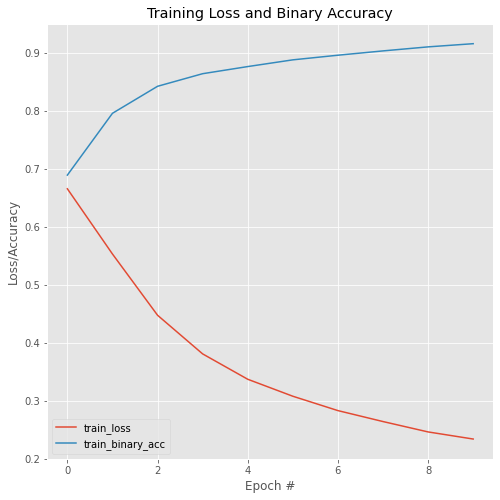

In [63]:
N = 10
plt.style.use("ggplot")
plt.figure(figsize=(8,8))
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_binary_acc")
plt.title("Training Loss and Binary Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()

#Inferencing on the Model

In [64]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

model.predict(examples)

array([[0.6119041 ],
       [0.4350201 ],
       [0.35451964]], dtype=float32)